<a href="https://colab.research.google.com/github/Choi-Jaehyuk/AIssd/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%91%EC%9A%A9_%EC%8B%A4%EC%8A%B51_%EB%AC%B8%EC%9E%90%EB%B0%8F%EC%9D%B4%EB%AF%B8%EC%A7%80%EC%9D%B8%EC%8B%9D%EC%9D%91%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pytorch implementation of image classification with Fully-connected layers


Implemented by June-Woo Kim, MLCL, 2022.03.28 (kaen2891@gmail.com)

MNIST 손글자 데이터를 인식하기 위한 이미지 분류 딥러닝 예제

라이브러리 셋업 1

In [1]:
import torch #pytorch 사용
import torch.nn as nn # neural network library from pytorch 사용
import torch.nn.functional as F # pytorch 내부의 F 함수 사용
import torch.optim as optim # optimizer 사용
from torchvision import datasets, transforms # 데이터셋을 가져오기 위한 라이브러리
from torch.autograd import Variable 
import matplotlib.pyplot as plt # 시각화를 위한 matplotlib 사용
import numpy as np #matrix 계산을 하기 위한 numpy 사용
print('Pytorch version is ',torch.__version__) # 현재 사용하는 pytorch 버전 출력

Pytorch version is  1.10.0+cu111


Seed 설정. 이를 통해서 매번 같은 결과 값이 나오기 위한 deterministic 한 code

In [2]:
random_seed = 2891
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
import random
random.seed(random_seed)

GPU 셋업. 정확히 출력 되는지 확인

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPU를 사용하기 위해서는 cuda로 설정해주어야 함

print('our device is', device) # 우리가 현재 사용하는 device는 cuda인가 cpu인가?

our device is cuda


Multi-layer Perceptron (MLP)

다층 퍼셉트론 네트워크

In [4]:
class MLP(nn.Module):
    def __init__(self, num_class, drop_prob):
        super(MLP, self).__init__()
        # input is 28x28
        # need for flatten ==> 784
        self.dropout = nn.Dropout(p=drop_prob)
        self.linear1 = nn.Linear(784, 128) # 첫 번째 layer의 hidden size를 784로 input으로 받고, 128을 출력 hidden으로 emit
        self.linear2 = nn.Linear(128, 64) # 두 번째 layer의 hidden size를 128로 input으로 받고, 64를 출력 hidden으로 emit
        '''
        Analysis1. linear1과 linear2 layer의 hidden size를 변경하면서 layer를 더 쌓아서 분석
        '''
        self.reduce_layer = nn.Linear(64, num_class) # 마지막 hidden size를 입력으로 받은 뒤 num_class 만큼 (클래스 개수) 줄임
        self.logsoftmax = nn.LogSoftmax(dim=1)
       
    def forward(self, x): 
        # need for flatten ==> 784
        x = self.dropout(F.relu(self.linear1(x.view(-1, 784)))) #x는 1 * 28 * 28의 크기인데, Fully-connected layer를 사용하기 위해서는 다 펴주어야 함. 즉 flatten을 시켜서 784로 만들어야 함. 이를 위해 pytorch의 view 함수를 사용함
        # Q1. 위를 거친 x의 output size는?
        # 힌트: print(x.size())
        x = self.dropout(F.relu(self.linear2(x)))
        # Q2. 위를 거친 x의 output size는?
        '''
        Analysis2. linear1과 linear2 layer의 hidden size를 변경하면서 layer를 더 쌓아서 분석하기. 위에서 추가한 layer를 여기에서 입력으로 넣음
        '''
        output = self.reduce_layer(x)
        # Q3. 마지막 output layer를 거친 x의 size는?

        return self.logsoftmax(output) #log softmax 함수 사용, 왜 log softmax를 사용하는가? 링크 참조: https://junstar92.tistory.com/118

모델 호출 및 gpu에 설정

In [5]:
model = MLP(10, 0.3)
model.to(device)

MLP(
  (dropout): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (reduce_layer): Linear(in_features=64, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

모델이 어떻게 구성되어있는지 확인

In [6]:
#model shape
for p in model.parameters():
    print(p.size())

torch.Size([128, 784])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


모델의 learnable parameter 개수 체크

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_param = count_parameters(model)
print('learnable parameters of model == ', model_param)

learnable parameters of model ==  109386


딥러닝 모델의 hyperparameter 설정 (batch size, learning rate)

In [8]:
batch_size = 64
lr = 1e-5
epochs = 5

MNIST 데이터 셋업 (자동 다운로드)

In [9]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),batch_size=batch_size, shuffle=True)
print(len(train_loader)) # 938개가 나옴. 왜냐하면 MNIST training set의 갯수는 60,000개이고 batch_size가 64이므로, 60,000/64 = 937.5이며, 반올림하여 938
test_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=False, transform=transforms.ToTensor()),batch_size=batch_size)
print(len(test_loader)) # 157개가 나옴. 왜냐하면 MNIST test set의 갯수는 10,000개이고 batch_size가 64이므로, 10,000/64 = 156.25이며, 반올림하여 157

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

938
157


Optimizer 선언 (Adam 사용)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=lr)

Training

In [11]:
model.train()
total_loss = 0
total_acc = 0
train_loss = []
train_accuracy = []
i = 1
for epoch in range(epochs):
    for data, target in train_loader:
        data, target = Variable(data), Variable(target)
        data = data.to(device)        
       
        target = target.to(device)
         
        optimizer.zero_grad()
        output = model(data)
       
        loss = F.nll_loss(output, target)
        loss.backward()    # calc gradients
       
        total_loss += loss.detach().cpu()
       
        train_loss.append(total_loss/i)
        optimizer.step()   # update gradients
       
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(target.data).sum()/batch_size*100
       
        total_acc += accuracy.detach().cpu()
       
        train_accuracy.append(total_acc/i)
       
        if i % 10 == 0:
            print('Epoch: {}\t Training Step: {}\tLoss: {:.3f}\t Training accuracy: {:.3f}'.format(epoch+1, i, loss, accuracy))
        i += 1
    print('Epoch: {} finished'.format(epoch+1))

Epoch: 1	 Training Step: 10	Loss: 2.310	 Training accuracy: 4.688
Epoch: 1	 Training Step: 20	Loss: 2.295	 Training accuracy: 4.688
Epoch: 1	 Training Step: 30	Loss: 2.287	 Training accuracy: 15.625
Epoch: 1	 Training Step: 40	Loss: 2.299	 Training accuracy: 3.125
Epoch: 1	 Training Step: 50	Loss: 2.302	 Training accuracy: 6.250
Epoch: 1	 Training Step: 60	Loss: 2.298	 Training accuracy: 9.375
Epoch: 1	 Training Step: 70	Loss: 2.284	 Training accuracy: 17.188
Epoch: 1	 Training Step: 80	Loss: 2.302	 Training accuracy: 18.750
Epoch: 1	 Training Step: 90	Loss: 2.298	 Training accuracy: 12.500
Epoch: 1	 Training Step: 100	Loss: 2.294	 Training accuracy: 14.062
Epoch: 1	 Training Step: 110	Loss: 2.294	 Training accuracy: 10.938
Epoch: 1	 Training Step: 120	Loss: 2.311	 Training accuracy: 14.062
Epoch: 1	 Training Step: 130	Loss: 2.292	 Training accuracy: 6.250
Epoch: 1	 Training Step: 140	Loss: 2.290	 Training accuracy: 21.875
Epoch: 1	 Training Step: 150	Loss: 2.286	 Training accuracy: 12

Plot

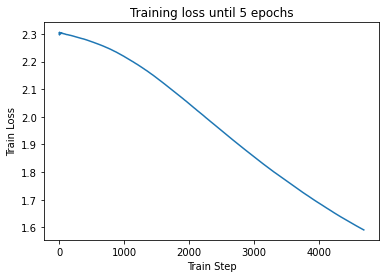

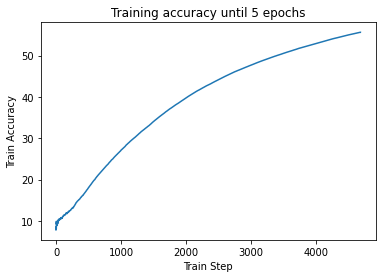

In [12]:
plt.figure()
plt.title('Training loss until 5 epochs')
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Train Step')
plt.ylabel('Train Loss')
plt.show()
#plt.savefig('./train_loss_result.png')

plt.figure()
plt.title('Training accuracy until 5 epochs')
plt.plot(np.arange(len(train_accuracy)), train_accuracy)
plt.xlabel('Train Step')
plt.ylabel('Train Accuracy')

plt.show()
#plt.savefig('./train_accuracy_result.png')


Evaluation

In [13]:
with torch.no_grad():
    model.eval()
    correct = 0
   
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        prediction = output.data.max(1)[1]
        correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 83.66%
